In [1]:
import pandas as pd

In [2]:
crime = pd.read_csv("crime_weather_preprocessed")
print(crime.columns)
print(crime.shape[0])

Index(['dow', 'hour_of_day', 'offense_date', 'temp_max', 'temp_min',
       'daylight_duration', 'precipitation_sum', 'precipitation_hours',
       'extracted_month', 'extracted_day', 'ucr_desc_numeric',
       'offense_year_numeric', 'time_block_numeric', 'census_tract_numeric',
       'census_block_numeric'],
      dtype='object')
360042


In [3]:
crime['offense_date'] = pd.to_datetime(crime['offense_date'], errors='coerce')

crime.set_index('offense_date', inplace=True)

In [4]:
crime_time_series = crime.groupby(['census_tract_numeric', pd.Grouper(freq='W')]).agg({
    'dow': 'mean',  
    'hour_of_day': 'mean',
    'extracted_month': 'mean',
    'extracted_day': 'mean',
    'temp_max': 'mean',
    'temp_min': 'mean',
    'daylight_duration': 'mean',
    'precipitation_sum': 'mean',
    'precipitation_hours': 'mean',
    'time_block_numeric': 'mean'
}).reset_index()

crime_time_series['Crime_Count_W'] = crime.groupby(['census_tract_numeric', pd.Grouper(freq='W')]).size().values

crime_time_series = crime_time_series.drop(columns=['offense_date'])

crime_time_series

,census_tract_numeric,dow,hour_of_day,extracted_month,extracted_day,temp_max,temp_min,daylight_duration,precipitation_sum,precipitation_hours,time_block_numeric,Crime_Count_W
0,0,2.000000,6.000000,1.0,1.000000,12.290450,1.895451,33267.093750,0.068898,16.500000,1.500000,2
1,0,6.000000,15.400000,1.0,12.200000,49.086680,19.170680,34008.580469,0.668504,15.400000,0.200000,5
2,0,1.333333,4.000000,1.0,19.000000,39.861799,27.231801,34686.420573,0.120735,10.666667,2.666667,3
3,0,3.666667,19.000000,1.0,24.000000,43.338799,28.158801,35223.052083,0.041995,3.333333,0.333333,3
4,0,6.142857,14.571429,2.0,2.285714,34.242929,16.654357,36431.930804,0.022497,5.714286,0.714286,7
...,...,...,...,...,...,...,...,...,...,...,...,...
41368,359,5.000000,16.000000,8.0,1.000000,75.513199,66.063202,51790.316406,0.000000,0.000000,0.000000,1
41369,359,4.000000,16.000000,4.0,1.000000,43.680199,38.100201,45827.394531,0.027559,6.000000,0.000000,1
41370,359,4.000000,16.000000,3.0,24.000000,71.622498,52.812500,44452.273438,0.043307,4.000000,0.000000,1
41371,359,2.000000,19.000000,5.0,18.000000,72.120201,50.160198,52665.191406,0.000000,0.000000,1.000000,1


In [5]:
crime_time_series.columns

Index(['census_tract_numeric', 'dow', 'hour_of_day', 'extracted_month',
       'extracted_day', 'temp_max', 'temp_min', 'daylight_duration',
       'precipitation_sum', 'precipitation_hours', 'time_block_numeric',
       'Crime_Count_W'],
      dtype='object')

In [6]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def k_fold_cross_validation(model, X, y, k=5, random_state=42):
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    fold_metrics = []

    mae_list, rmse_list, r2_list = [], [], []
    all_y_test = [] 
    all_y_pred = []

    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        all_y_test.extend(y_test)
        all_y_pred.extend(y_pred)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)
        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)

        print(f"Fold {fold + 1} Metrics:")
        print(f"  Mean Absolute Error (MAE): {mae}")
        print(f"  Root Mean Squared Error (RMSE): {rmse}")
        print(f"  R² Score: {r2}\n")

        fold_metrics.append((mae, rmse, r2))

    avg_mae = np.mean(mae_list)
    avg_rmse = np.mean(rmse_list)
    avg_r2 = np.mean(r2_list)

    print(f"Average MAE across {k} folds: {avg_mae}")
    print(f"Average RMSE across {k} folds: {avg_rmse}")
    print(f"Average R² Score across {k} folds: {avg_r2}")

    plt.figure(figsize=(12, 8))
    plt.plot(all_y_test, label='Actual Crime Count', color='blue')
    plt.plot(all_y_pred, label='Predicted Crime Count', linestyle='--', color='red')
    plt.legend()
    plt.title(f'Actual vs. Predicted Crime Count (Weekly) - Comprehensive Plot Across {k} Folds')
    plt.xlabel('Combined Test Samples from All Folds')
    plt.ylabel('Crime Count')
    plt.show()

    return avg_mae, avg_rmse, avg_r2, fold_metrics

In [8]:
features = ['census_tract_numeric', 'dow', 'hour_of_day', 'extracted_month', 
            'extracted_day', 'temp_max', 'temp_min', 'daylight_duration', 
            'precipitation_sum', 'precipitation_hours', 'time_block_numeric']
X = crime_time_series[features]
y = crime_time_series['Crime_Count_W']

C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 1 Metrics:
  Mean Absolute Error (MAE): 2.794477341389728
  Root Mean Squared Error (RMSE): 3.942960361311807
  R² Score: 0.5902394946859031



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 2 Metrics:
  Mean Absolute Error (MAE): 2.775303927492447
  Root Mean Squared Error (RMSE): 3.9280375765026636
  R² Score: 0.6157705304336007



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3 Metrics:
  Mean Absolute Error (MAE): 2.8207927492447133
  Root Mean Squared Error (RMSE): 3.954562613265296
  R² Score: 0.6017414378309298



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 4 Metrics:
  Mean Absolute Error (MAE): 2.7250483442107805
  Root Mean Squared Error (RMSE): 3.9714239915510343
  R² Score: 0.6182137051364194



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 5 Metrics:
  Mean Absolute Error (MAE): 2.815565627266135
  Root Mean Squared Error (RMSE): 4.404249180188295
  R² Score: 0.5847830841033848

Average MAE across 5 folds: 2.7862375979207608
Average RMSE across 5 folds: 4.040246744563819
Average R² Score across 5 folds: 0.6021496504380476


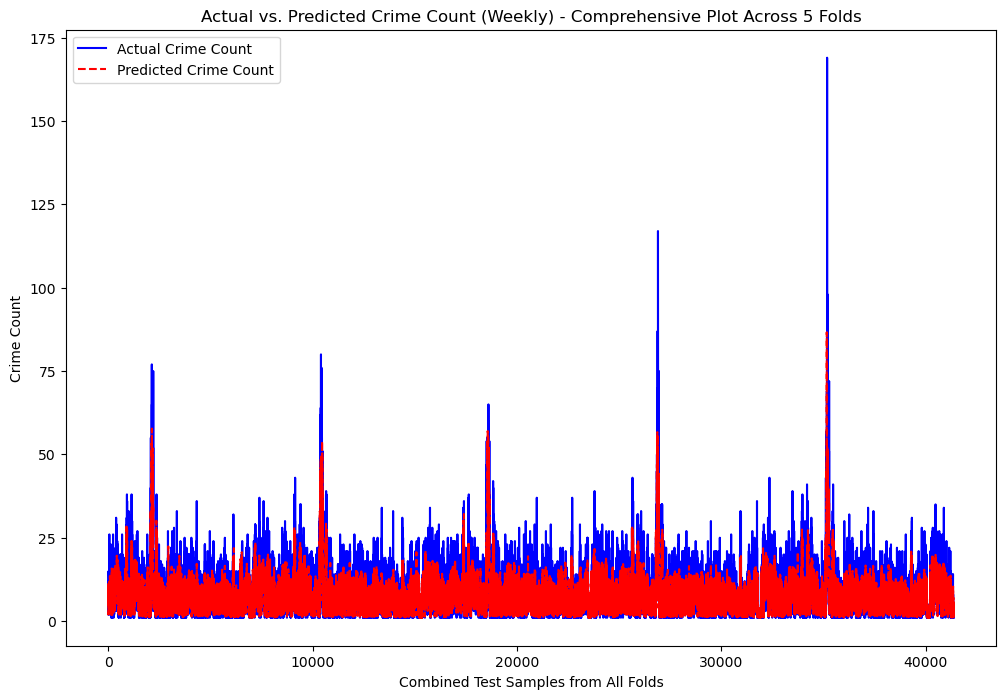

In [9]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
avg_mae, avg_rmse, avg_r2, metrics = k_fold_cross_validation(rf_model, X, y)

C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 1 Metrics:
  Mean Absolute Error (MAE): 2.487246780196863
  Root Mean Squared Error (RMSE): 3.6085970833388603
  R² Score: 0.6567883491516113



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 2 Metrics:
  Mean Absolute Error (MAE): 2.4482361562032353
  Root Mean Squared Error (RMSE): 3.593524944227336
  R² Score: 0.6784261465072632



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3 Metrics:
  Mean Absolute Error (MAE): 2.477998304576627
  Root Mean Squared Error (RMSE): 3.584339387485079
  R² Score: 0.6728202104568481



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 4 Metrics:
  Mean Absolute Error (MAE): 2.4172416722288514
  Root Mean Squared Error (RMSE): 3.6327125631066512
  R² Score: 0.680559515953064



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 5 Metrics:
  Mean Absolute Error (MAE): 2.504237541464239
  Root Mean Squared Error (RMSE): 3.994573399888635
  R² Score: 0.6584359407424927

Average MAE across 5 folds: 2.466992090933963
Average RMSE across 5 folds: 3.6827494756093118
Average R² Score across 5 folds: 0.6694060325622558


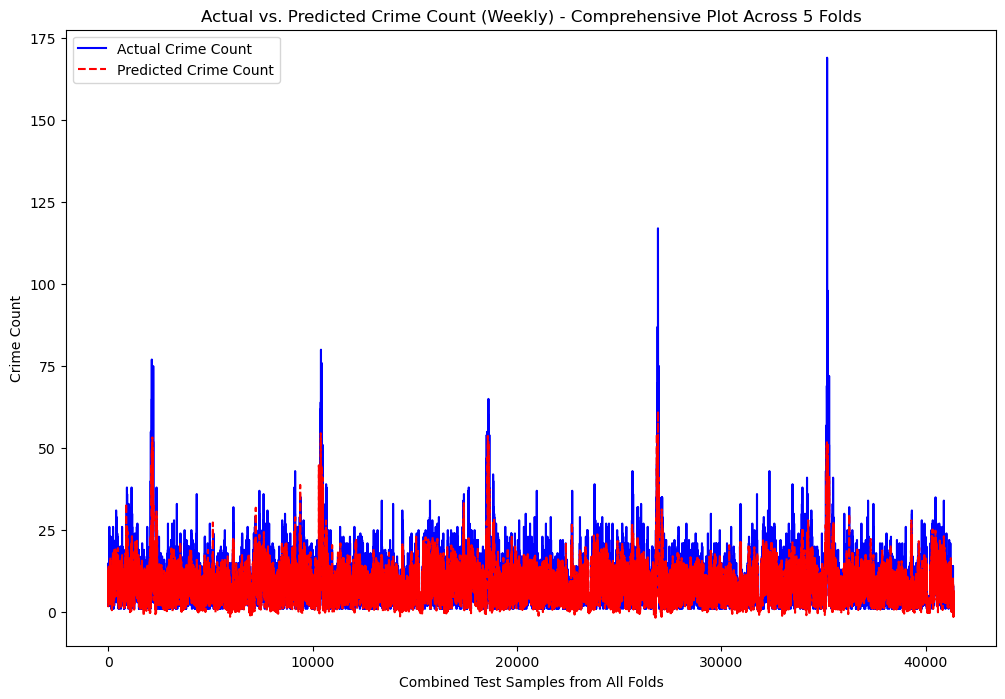

In [10]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42)
avg_mae, avg_rmse, avg_r2, metrics = k_fold_cross_validation(xgb_model, X, y)

In [12]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

timesteps = 24  
features = ['census_tract_numeric', 'dow', 'hour_of_day', 'extracted_month', 'extracted_day', 'temp_max', 
            'temp_min', 'daylight_duration', 'precipitation_sum', 'precipitation_hours', 
            'time_block_numeric']
target = 'Crime_Count_W'

scaler = MinMaxScaler()
crime_time_series[features] = scaler.fit_transform(crime_time_series[features])

X = crime_time_series[features].values
y = crime_time_series[target].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_generator = TimeseriesGenerator(X_train, y_train, length=timesteps, batch_size=64)
val_generator = TimeseriesGenerator(X_val, y_val, length=timesteps, batch_size=64)

X_transformed, y_transformed = train_generator[0]

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def build_model(input_shape):
    model = Sequential([

        LSTM(256, activation='relu', return_sequences=True, input_shape=input_shape,
             kernel_regularizer=l2(0.001)),
        Dropout(0.4),

        LSTM(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.4),

        GRU(64, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.3),

        GRU(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),

        Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(1)  
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mae')
    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)

input_shape = (timesteps, X_train.shape[1])  # timesteps, features
advanced_model = build_model(input_shape)

history = advanced_model.fit(
    train_generator, 
    epochs=50, 
    validation_data=val_generator, 
    callbacks=[early_stopping, reduce_lr]
)

y_pred = advanced_model.predict(val_generator).flatten()

mae = mean_absolute_error(y_val[timesteps:], y_pred)
rmse = mean_squared_error(y_val[timesteps:], y_pred, squared=False)
r2 = r2_score(y_val[timesteps:], y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R² Score: {r2}")

plt.figure(figsize=(10, 6))
plt.plot(y_val[timesteps:], label='Actual Crime Count')
plt.plot(y_pred, label='Predicted Crime Count', linestyle='--')
plt.legend()
plt.title('Actual vs. Predicted Crime Count (Weekly)')
plt.xlabel('Time')
plt.ylabel('Crime Count')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.show()

C:\Users\singh\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
  1/517 ━━━━━━━━━━━━━━━━━━━━ 2:57:36 21s/step - loss: 8.4177

C:\Users\singh\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


517/517 ━━━━━━━━━━━━━━━━━━━━ 114s 182ms/step - loss: 5.6565 - val_loss: 4.5941 - learning_rate: 5.0000e-04
Epoch 2/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 106s 205ms/step - loss: 4.6842 - val_loss: 4.5914 - learning_rate: 5.0000e-04
Epoch 3/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 110s 213ms/step - loss: 4.6102 - val_loss: 4.5817 - learning_rate: 5.0000e-04
Epoch 4/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 111s 214ms/step - loss: 4.5462 - val_loss: 4.6915 - learning_rate: 5.0000e-04
Epoch 5/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 111s 214ms/step - loss: 4.5329 - val_loss: 4.6233 - learning_rate: 5.0000e-04
Epoch 6/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 110s 212ms/step - loss: 4.5045 - val_loss: 4.7424 - learning_rate: 5.0000e-04
Epoch 7/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 110s 214ms/step - loss: 4.4440 - val_loss: 4.5498 - learning_rate: 5.0000e-04
Epoch 8/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 110s 214ms/step - loss: 4.4752 - val_loss: 4.5590 - learning_rate: 5.0000e-04
Epoch 9/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 110s 214ms/step - loss: 4.4

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def build_rnn_model(input_shape):
    model = Sequential([

        SimpleRNN(256, activation='relu', input_shape=input_shape, return_sequences=True, 
                  kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        
        SimpleRNN(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        
        SimpleRNN(64, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.3),

        SimpleRNN(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),

        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(1) 
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0003), loss='mae')
    return model

input_shape = (X_transformed.shape[1], X_transformed.shape[2])
rnn_model = build_rnn_model(input_shape)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = rnn_model.fit(X_train, y_train, epochs=100, batch_size=64, 
                        validation_data=(X_val, y_val), verbose=1, 
                        callbacks=[reduce_lr, early_stopping])

y_pred = rnn_model.predict(X_val).flatten()

mae = mean_absolute_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R² Score: {r2}")

plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual Crime Count')
plt.plot(y_pred, label='Predicted Crime Count', linestyle='--')
plt.legend()
plt.title('Actual vs. Predicted Crime Count (Weekly)')
plt.xlabel('Time')
plt.ylabel('Crime Count')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.show()